In [2]:
import keras
import datetime
from keras.models import Model, load_model
import os
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from keras.layers import Input, UpSampling2D, Conv2D, Dense, Dropout, BatchNormalization, Flatten, Conv2DTranspose
import numpy as np
from skimage import io, color
from keras.preprocessing import image
import numpy as np
from skimage import io, color, transform
from scipy.spatial.distance import cdist
from matplotlib import pyplot as plt
import os
image_size = 256

now = datetime.datetime.now()

image_path = "drive/app/input/"

def read_image(img_id, dir):
    try:
        img = load_img(dir + "/" + img_id, target_size=(256,256))
        img = img_to_array(img)
        return img
    except:
        return None

def convLayer(input, filters, kernel_size,  stride=1):
    return Conv2D(filters, kernel_size, padding="same", activation="relu", strides=stride)(input)

input_shape = (image_size, image_size, 1)

model_input = Input(shape = input_shape)

model_output = convLayer(model_input, 64, (3, 3))
model_output = convLayer(model_output, 64, (3, 3), stride=2)
model_output = BatchNormalization()(model_output)

model_output = convLayer(model_output, 128, (3, 3))
model_output = convLayer(model_output, 128, (3, 3), stride=2)
model_output = BatchNormalization()(model_output)

model_output = convLayer(model_output, 256, (3, 3))
model_output = convLayer(model_output, 256, (3, 3), stride=2)
model_output = BatchNormalization()(model_output)

model_output = convLayer(model_output, 512, (3, 3))
model_output = convLayer(model_output, 512, (3, 3))
model_output = BatchNormalization()(model_output)

model_output = convLayer(model_output, 512, (3, 3))
model_output = convLayer(model_output, 512, (3, 3))
model_output = BatchNormalization()(model_output)

model_output = UpSampling2D((2, 2))(model_output) #not sure if this or deconvolution
model_output = convLayer(model_output, 256, (3, 3))
model_output = BatchNormalization()(model_output)

model_output = UpSampling2D((2, 2))(model_output) 
model_output = convLayer(model_output, 64, (3, 3))
model_output = BatchNormalization()(model_output)

model_output = UpSampling2D((2, 2))(model_output) 
model_output = Conv2D(2, (3, 3), activation="tanh", padding="same")(model_output)

model =  Model(inputs=model_input, outputs=model_output)

model.load_weights("../MSE_Train_2_8_model_weights.h5")
model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])



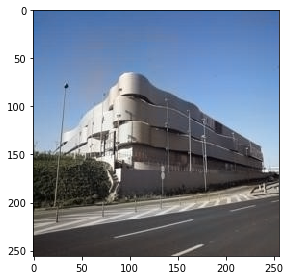

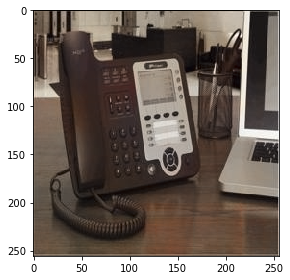

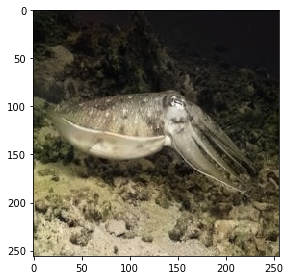

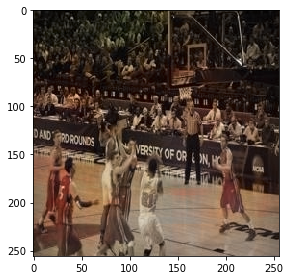

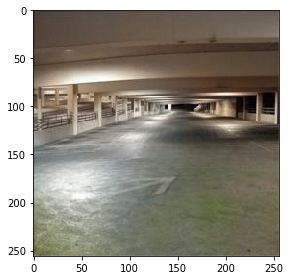

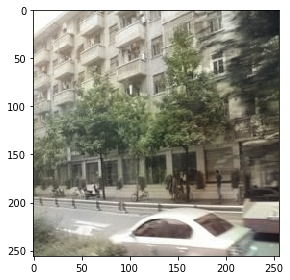

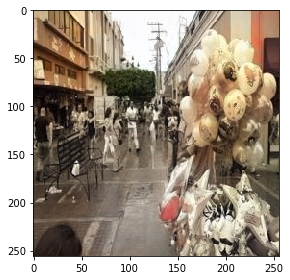

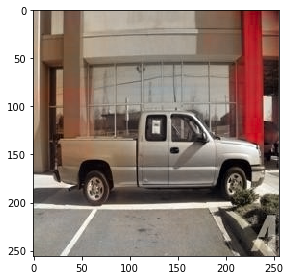

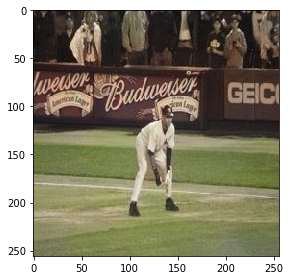

In [10]:
directory = "../data"
files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
Xtest = []
for image in files:
    img = read_image(image, directory)
    if not img is None:
        img = np.array(img, dtype=float)
        Xtest.append(img)

Xtest = np.array(Xtest, dtype=float)
Xtest = 1.0/255*Xtest
inputs = color.rgb2lab(Xtest)[:, :, :, 0]
inputs_2 = inputs / 100
inputs_2 = inputs_2 - 0.5
inputs_2 = inputs_2.reshape(inputs_2.shape+(1,))
inputs = inputs.reshape(inputs.shape+(1,))

# Test model
output = model.predict(inputs_2)
output = output * 128

# Output colorizations
for i in range(len(output)):
    cur = np.zeros((image_size, image_size, 3))
    cur[:,:,0] = inputs[i][:,:,0]
    cur[:,:,1:] = output[i]
    io.imshow(color.lab2rgb(cur))
    plt.show()